In [1]:
import sys
print(sys.executable)

c:\Users\jhon1\data\.venv\Scripts\python.exe


In [2]:
import requests
import pandas as pd
from datetime import datetime
from geopy.geocoders import Nominatim
import time
import numpy as np
import matplotlib.pyplot as plt
import pytz

In [ ]:
# Função para Coletar os Dados da API Waze com retry exponencial com no máximo de 3 tentativas
def get_data_from_api(url, max_retries=3, backoff_factor=1):
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(url)
            response.raise_for_status()  # Vai gerar erro se o status não for 200
            return response.json()  # Retorna o conteúdo como JSON
        except requests.exceptions.RequestException as e:
            retries += 1
            print(f"Erro na requisição: {e}. Tentativa {retries}/{max_retries}")
            time.sleep(backoff_factor ** retries)  # Exponencial backoff
    return None  # Caso não consiga após 3 tentativas

In [ ]:
# Função de Enriquecimento do Waze (Geocoding para bairro e zona) - Usando Nominatim
def enrich_waze_data(df_alerts):
    geolocator = Nominatim(user_agent="waze_enrichment")
    
    # Verificar se as colunas 'location_x' (longitude) e 'location_y' (latitude) existem
    if 'location_x' not in df_alerts.columns or 'location_y' not in df_alerts.columns:
        print("Erro: colunas 'location_x' e/ou 'location_y' não encontradas.")
        return df_alerts
    
    def reverse_geocode(row):
        try:
            # Usando location_x como longitude e location_y como latitude
            latitude, longitude = row['location_y'], row['location_x']
            print(f"Geocodificando: lat={latitude}, lon={longitude}")
            location = geolocator.reverse((latitude, longitude), language='pt', exactly_one=True)
            if location:
                address = location.raw.get('address', {})
                return address.get('suburb', None), address.get('zone', None)
        except Exception as e:
            print(f"Erro no geocoding: {e}")
        return None, None
    
    # Enriquecer com bairro e zona
    df_alerts[['bairro', 'zona']] = df_alerts.apply(reverse_geocode, axis=1, result_type="expand")
    return df_alerts

In [5]:
# Função de Limpeza e Tipagem dos Dados
def clean_and_convert(df, date_column, datetime_format="%Y-%m-%dT%H:%M:%S%z"):
    # Converter colunas de data para datetime timezone-aware
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce', format=datetime_format)
    
    # Substituir valores inválidos por NULL (NaN)
    df.replace({"N/D": np.nan, "-": np.nan, "": np.nan}, inplace=True)
    
    # Convertendo vírgulas para ponto e depois para float nas colunas numéricas
    for col in df.select_dtypes(include=[object]).columns:
        if df[col].str.contains(',').any():
            df[col] = df[col].str.replace(',', '.').astype(float)
    
    # Normalizando os nomes das colunas para snake_case
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]
    
    return df

In [6]:
# Função de Limpeza e Tipagem dos Dados
def clean_and_convert(df, date_column, datetime_format="%Y-%m-%dT%H:%M:%S%z"):
    # Converter colunas de data para datetime timezone-aware
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce', format=datetime_format)
    
    # Substituir valores inválidos por NULL (NaN)
    df.replace({"N/D": np.nan, "-": np.nan, "": np.nan}, inplace=True)
    
    # Convertendo vírgulas para ponto e depois para float nas colunas numéricas
    for col in df.select_dtypes(include=[object]).columns:
        if df[col].str.contains(',').any():
            df[col] = df[col].str.replace(',', '.').astype(float)
    
    # Normalizando os nomes das colunas para snake_case
    df.columns = [col.lower().replace(" ", "_") for col in df.columns]
    
    return df

In [7]:
# Função para Coletar e Processar os Dados Waze
def process_waze_data(start_date, end_date):
    # URL da API Waze
    waze_url = "https://www.waze.com/row-partnerhub-api/partners/14420996249/waze-feeds/c5c19146-e0f9-44a7-9815-3862c8a6ed67?format=csv&types=alerts,traffic&fa=true"
    waze_data = get_data_from_api(waze_url)

    # Se os dados forem no formato esperado (JSON)
    if isinstance(waze_data, dict):  
        alerts_data = waze_data.get('alerts', [])
        if alerts_data:
            # Criar DataFrame com os dados dos alerts
            df_alerts = pd.json_normalize(alerts_data, sep='_')  # "Normaliza" a estrutura aninhada
            
            # Filtrando os dados de acordo com o intervalo de tempo
            df_alerts['pubMillis'] = pd.to_datetime(df_alerts['pubMillis'], errors='coerce', unit='ms')
            
            # Garantir que as datas estejam no mesmo fuso horário (timezone-aware)
            tz = pytz.timezone('America/Sao_Paulo')  # Definir o fuso horário correto
            
            # Verificar se pubMillis já está com fuso horário, e se estiver, usar tz_convert()
            if df_alerts['pubMillis'].dt.tz is None:
                df_alerts['pubMillis'] = df_alerts['pubMillis'].dt.tz_localize('UTC').dt.tz_convert(tz)
            else:
                df_alerts['pubMillis'] = df_alerts['pubMillis'].dt.tz_convert(tz)
            
            # Converter as datas de string para datetime (timezone-aware) com o fuso horário desejado
            start_date = pd.to_datetime(start_date).tz_convert(tz)  # Converter diretamente para datetime
            end_date = pd.to_datetime(end_date).tz_convert(tz)  # Converter diretamente para datetime

            # Filtrando os dados no intervalo de tempo
            df_alerts = df_alerts[(df_alerts['pubMillis'] >= start_date) & (df_alerts['pubMillis'] <= end_date)]
            
            # Limpeza e conversão dos dados
            df_alerts_cleaned = clean_and_convert(df_alerts, 'pubMillis')  # 'pubMillis' é a data do alerta
            
            # Enriquecimento com geocoding (bairro e zona)
            df_alerts_enriched = enrich_waze_data(df_alerts_cleaned)
            
            return df_alerts_enriched
        else:
            print("Nenhum dado de alertas encontrado.")
            return None
    else:
        print("Erro: Dados não estão no formato esperado (JSON).")
        return None

In [8]:
# Função principal para orquestrar as etapas de coleta e processamento
def main():
    # Definir o intervalo de tempo desejado para a filtragem
    start_date = "2025-05-10T00:00:00-03:00"
    end_date = "2025-05-12T23:59:59-03:00"
    
    # Coletar e processar os dados do Waze
    df_alerts_enriched = process_waze_data(start_date, end_date)
    
    return df_alerts_enriched

# Rodar o script
df_alerts_enriched = main()

C:\Users\jhon1\AppData\Local\Temp\ipykernel_1096\813417987.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"N/D": np.nan, "-": np.nan, "": np.nan}, inplace=True)


Geocodificando: lat=-22.871211, lon=-43.763244
Geocodificando: lat=-22.92165, lon=-43.563784
Geocodificando: lat=-22.873631, lon=-43.764802
Geocodificando: lat=-22.97843, lon=-43.661612
Geocodificando: lat=-22.882434, lon=-43.570306
Geocodificando: lat=-22.887841, lon=-43.580402
Geocodificando: lat=-22.851739, lon=-43.364763
Geocodificando: lat=-22.899059, lon=-43.679193
Geocodificando: lat=-22.823469, lon=-43.369721
Geocodificando: lat=-22.872942, lon=-43.558411
Geocodificando: lat=-22.875735, lon=-43.222472
Geocodificando: lat=-22.923567, lon=-43.518415
Geocodificando: lat=-22.882348, lon=-43.605172
Geocodificando: lat=-22.748881, lon=-43.422826
Geocodificando: lat=-22.856336, lon=-43.540941
Geocodificando: lat=-22.944239, lon=-43.64406
Geocodificando: lat=-22.879598, lon=-43.563687
Geocodificando: lat=-22.875651, lon=-43.564754
Geocodificando: lat=-22.832079, lon=-43.762237
Geocodificando: lat=-22.877407, lon=-43.592332
Geocodificando: lat=-22.822885, lon=-43.759294
Geocodificando: 

In [9]:
df_alerts_enriched.head()

,country,city,reportrating,reportbymunicipalityuser,confidence,reliability,type,uuid,roadtype,magvar,subtype,street,pubmillis,location_x,location_y,reportdescription,bairro,zona
3,BR,Itaguaí,0,false,5,10,HAZARD,c0ac9472-0965-4c4c-a421-09ac49a5eccf,1,215,HAZARD_ON_ROAD_POT_HOLE,R. Equador,2025-05-10 14:53:24-03:00,-43.763244,-22.871211,NaN,None,None
8,BR,Rio de Janeiro,5,false,5,10,HAZARD,5e13d6f5-ba86-4a2b-bac6-88816a5e21a5,2,225,HAZARD_ON_ROAD_POT_HOLE,Est. do Monteiro,2025-05-12 10:15:45-03:00,-43.563784,-22.921650,NaN,Campo Grande,None
23,BR,Itaguaí,0,false,1,7,HAZARD,3af6613f-ff67-444e-980a-e44112fd3782,1,214,HAZARD_ON_ROAD_POT_HOLE,R. Maria Cândida,2025-05-12 13:20:35-03:00,-43.764802,-22.873631,NaN,None,None
27,BR,Rio de Janeiro,1,false,3,10,HAZARD,afd8c24c-8874-4b61-90fc-1a8cd7a67292,1,359,HAZARD_ON_ROAD_POT_HOLE,R. Uirauna,2025-05-11 14:01:55-03:00,-43.661612,-22.978430,NaN,Guaratiba,None
28,BR,Rio de Janeiro,2,false,1,7,HAZARD,03bef47b-f171-42db-a4b9-697d03b3c657,1,56,HAZARD_ON_ROAD_POT_HOLE,R. Soldado Francisco Savastana,2025-05-12 23:33:10-03:00,-43.570306,-22.882434,NaN,Campo Grande,None


In [10]:
df_alerts_enriched.dtypes

country                                                object
city                                                   object
reportrating                                            int64
reportbymunicipalityuser                               object
confidence                                              int64
reliability                                             int64
type                                                   object
uuid                                                   object
roadtype                                                int64
magvar                                                  int64
subtype                                                object
street                                                 object
pubmillis                   datetime64[ns, America/Sao_Paulo]
location_x                                            float64
location_y                                            float64
reportdescription                                     float64
bairro  

,country,city,reportrating,reportbymunicipalityuser,confidence,reliability,type,uuid,roadtype,magvar,subtype,street,pubmillis,location_x,location_y,reportdescription,bairro,zona
0,BR,Itaguaí,0,false,4,10,HAZARD,c0ac9472-0965-4c4c-a421-09ac49a5eccf,1.0,215,HAZARD_ON_ROAD_POT_HOLE,R. Equador,2025-05-10 14:53:24-03:00,-43.763244,-22.871211,NaN,None,None
1,BR,Rio de Janeiro,3,false,0,5,JAM,936bfb68-1ffd-48c6-b09b-9efb7069717b,2.0,274,JAM_HEAVY_TRAFFIC,R. Bernardo de Vasconcelos,2025-05-12 20:05:15-03:00,-43.427643,-22.876476,NaN,Realengo,None
2,BR,Niterói,3,false,0,5,JAM,a3c76609-edd5-41fb-a82f-a52698b0d183,3.0,95,JAM_HEAVY_TRAFFIC,BR-101 N Ponte Rio-Niterói,2025-05-12 20:16:21-03:00,-43.152421,-22.871462,NaN,Ilha da Conceição,None
3,BR,Rio de Janeiro,0,false,0,5,HAZARD,e04c2635-01d7-4454-acfd-7484085833d3,17.0,359,HAZARD_ON_ROAD_POT_HOLE,R. Nestor Tangerini,2025-05-12 18:21:46-03:00,-43.584952,-22.880076,NaN,Campo Grande,None
4,BR,Rio de Janeiro,5,false,5,10,HAZARD,5e13d6f5-ba86-4a2b-bac6-88816a5e21a5,2.0,225,HAZARD_ON_ROAD_POT_HOLE,Est. do Monteiro,2025-05-12 10:15:45-03:00,-43.563784,-22.921650,NaN,Campo Grande,None


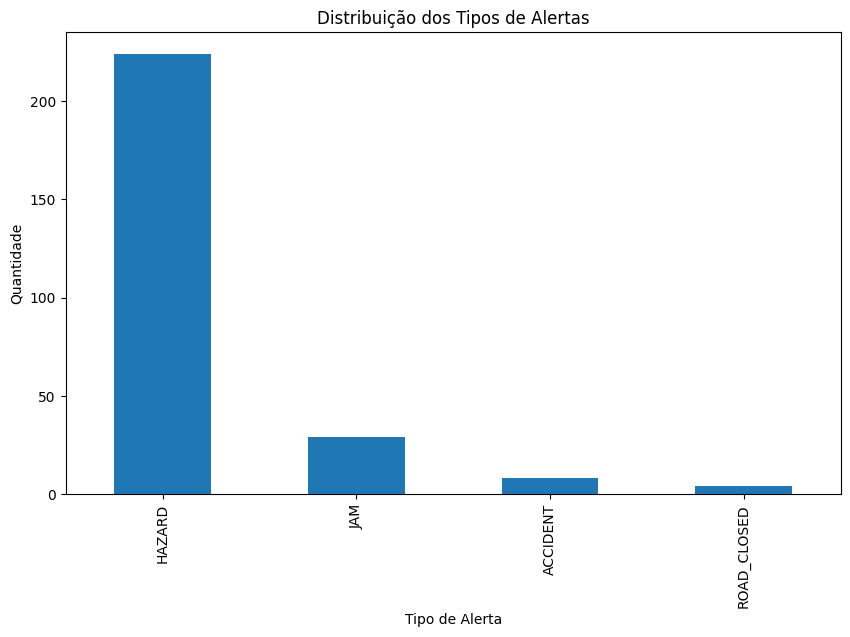

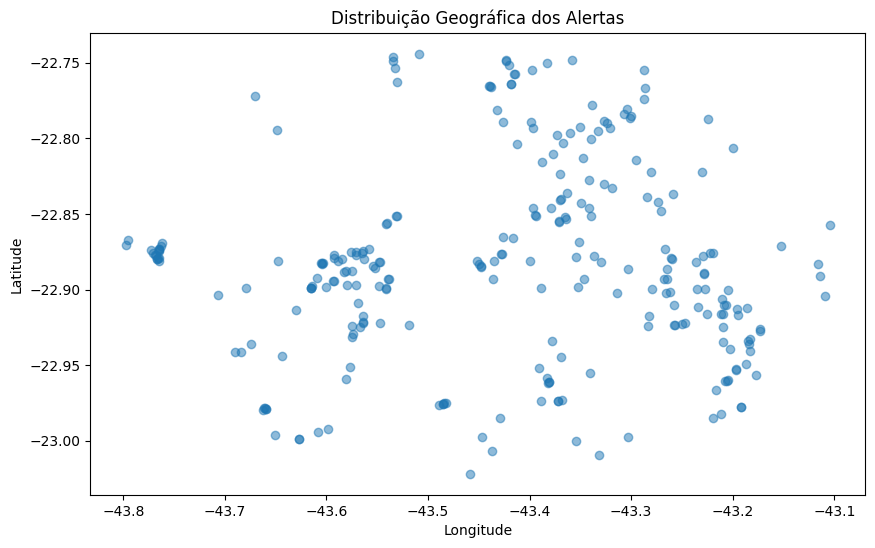

In [53]:
import matplotlib.pyplot as plt

# Verificar se o DataFrame está disponível
if df_alerts_enriched is not None:
    # Exibir as primeiras linhas do DataFrame para ver a estrutura dos dados
    display(df_alerts_enriched.head())

    # Visualizar as distribuições dos alertas por tipo, exemplo
    plt.figure(figsize=(10, 6))
    df_alerts_enriched['type'].value_counts().plot(kind='bar')
    plt.title('Distribuição dos Tipos de Alertas')
    plt.xlabel('Tipo de Alerta')
    plt.ylabel('Quantidade')
    plt.show()

    # Visualizar a distribuição geográfica dos alertas (latitude x longitude)
    plt.figure(figsize=(10, 6))
    plt.scatter(df_alerts_enriched['location_x'], df_alerts_enriched['location_y'], alpha=0.5)
    plt.title('Distribuição Geográfica dos Alertas')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [31]:
# Importação das bibliotecas:
import requests
import pandas as pd
from datetime import datetime
from geopy.geocoders import Nominatim
import time
import numpy as np

In [32]:
# Função para Coletar os Dados da API Waze:
# A função get_data_from_api vai consumir a API com retries exponenciais.

def get_data_from_api(url, max_retries=3, backoff_factor=1):
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(url)
            response.raise_for_status()  # Vai gerar erro se o status não for 200
            return response.json()  # Agora retorna JSON diretamente
        except requests.exceptions.RequestException as e:
            retries += 1
            print(f"Erro na requisição: {e}. Tentativa {retries}/{max_retries}")
            time.sleep(backoff_factor ** retries)  # Exponencial backoff
    return None  # Caso não consiga após 3 tentativas

In [24]:
# Função para Coletar os Dados da API Waze:
# A função get_data_from_api vai consumir a API com retries exponenciais.

def get_data_from_api(url, max_retries=3, backoff_factor=1):
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(url)
            response.raise_for_status()  # Vai gerar erro se o status não for 200
            return response.text  # Retorna o conteúdo como texto (CSV)
        except requests.exceptions.RequestException as e:
            retries += 1
            print(f"Erro na requisição: {e}. Tentativa {retries}/{max_retries}")
            time.sleep(backoff_factor ** retries)  # Exponencial backoff
    return None  # Caso não consiga após 3 tentativas

In [33]:
# Consumindo a API Waze:
waze_url = "https://www.waze.com/row-partnerhub-api/partners/14420996249/waze-feeds/c5c19146-e0f9-44a7-9815-3862c8a6ed67?format=csv&types=alerts,traffic&fa=true"
waze_data = get_data_from_api(waze_url)

In [34]:
# Agora vamos verificar o tipo da resposta (JSON ou CSV)
if isinstance(waze_data, dict):  # Se a resposta for um dicionário JSON
    alerts_data = waze_data.get('alerts', [])
    if alerts_data:
        # Criar DataFrame com os dados dos alerts
        df_alerts = pd.json_normalize(alerts_data, sep='_')  # "Normaliza" a estrutura aninhada
        print(df_alerts.head())  # Exibir as primeiras linhas
    else:
        print("Nenhum dado de alertas encontrado.")
else:
    print("Erro: Dados não estão no formato esperado (CSV ou JSON).")

  country            city  reportRating reportByMunicipalityUser  confidence  \
0      BR  Rio de Janeiro             5                    false           0   
1      BR  Rio de Janeiro             2                    false           2   
2      BR  Rio de Janeiro             5                    false           0   
3      BR  Rio de Janeiro             0                    false           1   
4      BR  Rio de Janeiro             0                    false           0   

   reliability    type                                  uuid  roadType  \
0            5     JAM  9d66d279-3861-4550-9230-f855e3bd446c       3.0   
1           10     JAM  9f818af4-749b-4e07-af24-1c6708b424b2       3.0   
2            5     JAM  936a2857-3b25-4ab1-8380-1423fbabf807       6.0   
3            8     JAM  ceef4bb9-2d50-48e2-8f79-63469d3f9702       2.0   
4            5  HAZARD  201e094d-e3a4-4935-8813-fcd2ec5ed37b      17.0   

   magvar                  subtype                      street      pubMil

In [37]:
# Ver número de linhas e colunas
print(f"Número de linhas: {df_alerts.shape[0]}")
print(f"Número de colunas: {df_alerts.shape[1]}")

Número de linhas: 644
Número de colunas: 16
